In [2]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + '/../src')

In [3]:
import wandb
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pickle
from collections import deque
from recurrent.parameters import AllLogs
import jax 
jax.config.update("jax_platform_name", "cpu")


In [4]:
run = wandb.init()
artifact = run.use_artifact('wlp9800-new-york-university/rnn-test-src/logs_vmgz1mpe:v0', type='logs')
artifact_dir = artifact.download()

logs_path = os.path.join(artifact_dir, 'logs.pkl')

with open(logs_path, 'rb') as f:
    logs_data: AllLogs = pickle.load(f)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wlp9800 (wlp9800-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


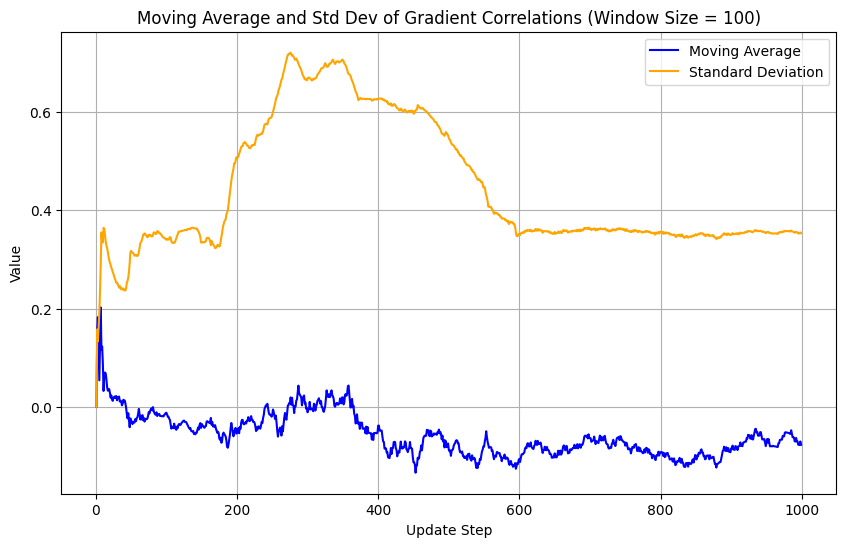

In [6]:
import jax.numpy as jnp

def compute_correlation(g1, g2):
    """Compute Pearson correlation between two gradient vectors using JAX."""
    g1 = jnp.array(g1)
    g2 = jnp.array(g2)
    g1_centered = g1 - jnp.mean(g1)
    g2_centered = g2 - jnp.mean(g2)
    numerator = jnp.dot(g1_centered, g2_centered)
    denominator = jnp.linalg.norm(g1_centered) * jnp.linalg.norm(g2_centered)
    return numerator / denominator if denominator != 0 else 0

def track_gradient_stats(gradients, window_size=100):
    """Track moving average and std of gradient correlations with JAX."""
    correlations = deque(maxlen=window_size)
    moving_avg = []
    moving_std = []
    
    for i in range(1, len(gradients)):
        corr = compute_correlation(gradients[i], gradients[i-1])
        correlations.append(corr)
        
        if len(correlations) >= 1:
            avg = jnp.mean(jnp.array(correlations))
            std = jnp.std(jnp.array(correlations)) if len(correlations) > 1 else 0
            moving_avg.append(avg)
            moving_std.append(std)
    
    return moving_avg, moving_std

# Generate gradients
gradients = logs_data.train_gradient

# Compute stats
moving_avg, moving_std = track_gradient_stats(gradients, window_size=100)

# Plotting
plt.figure(figsize=(10, 6))
updates = range(1, len(moving_avg) + 1)  # x-axis: update steps
plt.plot(updates, moving_avg, label="Moving Average", color="blue")
plt.plot(updates, moving_std, label="Standard Deviation", color="orange")
plt.xlabel("Update Step")
plt.ylabel("Value")
plt.title("Moving Average and Std Dev of Gradient Correlations (Window Size = 100)")
plt.legend()
plt.grid(True)
plt.show()

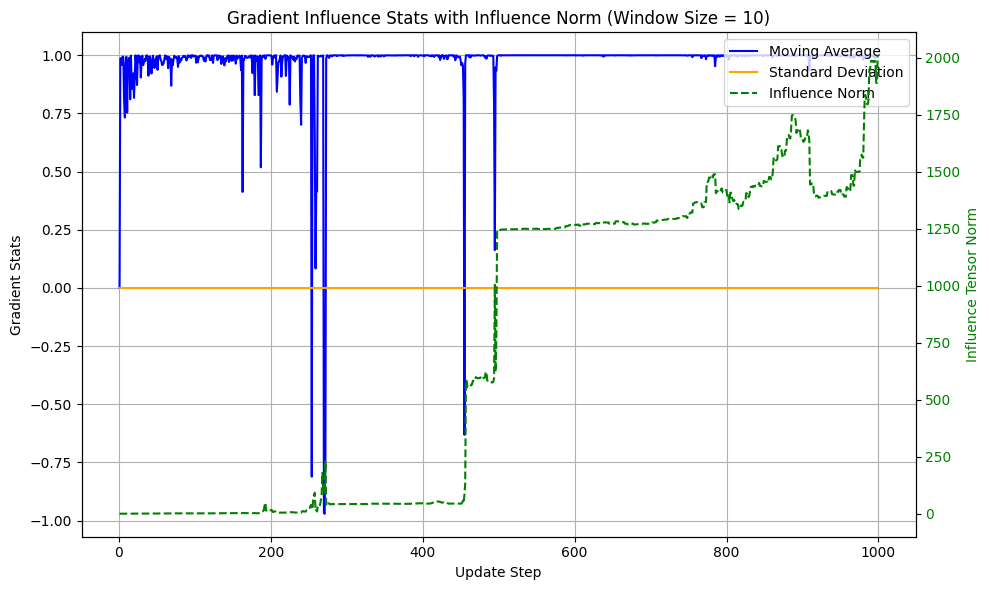

In [7]:
# Extract and process data
influence_tensor = jnp.squeeze(logs_data.outer_influence_tensor)
moving_avg, moving_std = track_gradient_stats(influence_tensor, window_size=1)
influence_norms = jnp.linalg.norm(influence_tensor, axis=-1)  # Adjust axis if needed

updates = range(1, len(moving_avg) + 1)

# Plotting with twin y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis: Moving avg and std
ax1.plot(updates, moving_avg, label="Moving Average", color="blue")
ax1.plot(updates, moving_std, label="Standard Deviation", color="orange")
ax1.set_xlabel("Update Step")
ax1.set_ylabel("Gradient Stats", color="black")
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Twin axis: Influence tensor norm
ax2 = ax1.twinx()
ax2.plot(updates, influence_norms[:len(moving_avg)], label="Influence Norm", color="green", linestyle='--')
ax2.set_ylabel("Influence Tensor Norm", color="green")
ax2.tick_params(axis='y', labelcolor='green')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Gradient Influence Stats with Influence Norm (Window Size = 10)")
plt.tight_layout()
plt.show()

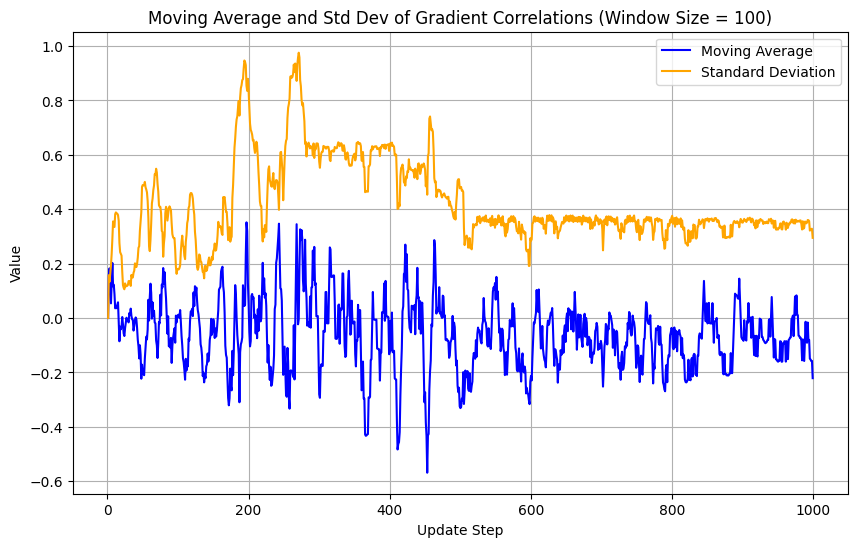

In [8]:
moving_avg, moving_std = track_gradient_stats(jnp.squeeze(logs_data.immediate_influence_tensor), window_size=10)

# Plotting
plt.figure(figsize=(10, 6))
updates = range(1, len(moving_avg) + 1)  # x-axis: update steps
plt.plot(updates, moving_avg, label="Moving Average", color="blue")
plt.plot(updates, moving_std, label="Standard Deviation", color="orange")
plt.xlabel("Update Step")
plt.ylabel("Value")
plt.title("Moving Average and Std Dev of Gradient Correlations (Window Size = 100)")
plt.legend()
plt.grid(True)
plt.show()

x_t range (t=0): max=0.0, min(non-zero)=nan
x_t range (t=1): max=0.08435382694005966, min(non-zero)=1.8215450836578384e-06
x_t range (t=2): max=0.09186835587024689, min(non-zero)=8.90126102603972e-07
x_t range (t=3): max=0.09067397564649582, min(non-zero)=1.5715140762040392e-06
x_t range (t=4): max=0.09238050878047943, min(non-zero)=8.929458999773487e-06
x_t range (t=5): max=0.09101554751396179, min(non-zero)=1.2121745385229588e-06
x_t range (t=6): max=0.086765818297863, min(non-zero)=8.30087810754776e-06
x_t range (t=7): max=0.09667999297380447, min(non-zero)=9.333074558526278e-06
x_t range (t=8): max=0.08238484710454941, min(non-zero)=3.5017146728932858e-06
x_t range (t=9): max=0.09009503573179245, min(non-zero)=2.104970917571336e-06
x_t range (t=10): max=0.09843748807907104, min(non-zero)=3.6730896681547165e-05
x_t range (t=11): max=0.10552839934825897, min(non-zero)=9.16607677936554e-06
x_t range (t=12): max=0.09790469706058502, min(non-zero)=9.446230251342058e-07
x_t range (t=13):

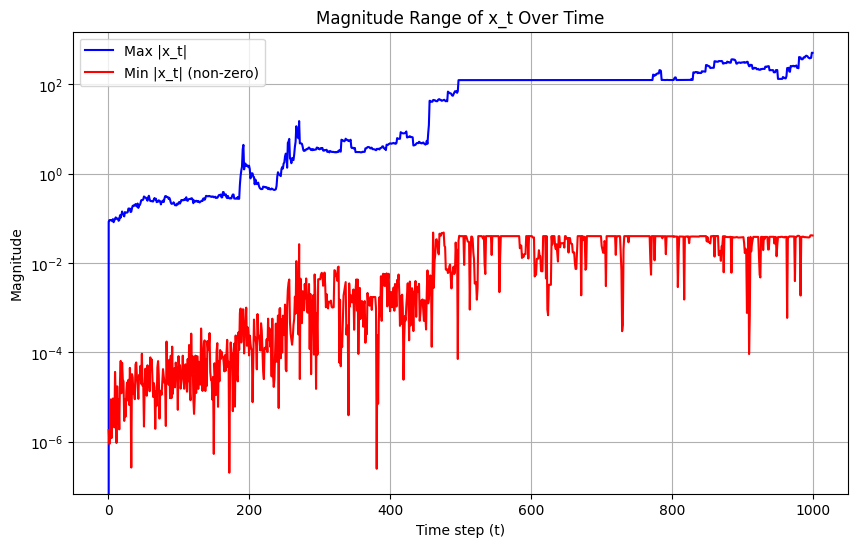

In [9]:
x_t = jnp.squeeze(logs_data.outer_influence_tensor)

# Ensure x_t is 2D (T, n)
if x_t.ndim == 1:
    x_t = x_t[:, None]  # Reshape to (T, 1) if 1D
T = x_t.shape[0]

# Compute max and min (non-zero) magnitudes
max_abs_x = np.zeros(T)
min_abs_x = np.zeros(T)

for t in range(T):
    abs_x = jnp.abs(x_t[t])
    max_abs_x[t] = jnp.max(abs_x).item()  # Convert to scalar
    # Min of non-zero elements
    non_zero = abs_x[abs_x != 0]
    min_abs_x[t] = jnp.min(non_zero).item() if non_zero.size > 0 else np.nan
    print(f"x_t range (t={t}): max={max_abs_x[t]}, min(non-zero)={min_abs_x[t]}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_abs_x, label="Max |x_t|", color="blue")
plt.plot(min_abs_x, label="Min |x_t| (non-zero)", color="red")
plt.yscale("log")  # Log scale to handle magnitude differences
plt.xlabel("Time step (t)")
plt.ylabel("Magnitude")
plt.title("Magnitude Range of x_t Over Time")
plt.legend()
plt.grid(True)
plt.show()